In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os

2025-11-07 16:43:23.959790: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 16:43:24.013445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-07 16:43:25.658816: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_dir = r"Training"
valid_dir = r"Validation"
test_dir  = r"Testing"

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32,
    class_mode='categorical', shuffle=True
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=(224,224), batch_size=32,
    class_mode='categorical', shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224,224), batch_size=32,
    class_mode='categorical', shuffle=False
)

Found 10888 images belonging to 2 classes.
Found 985 images belonging to 2 classes.
Found 923 images belonging to 2 classes.


In [5]:
cw = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(cw))
print("Class Weights:", class_weights)

Class Weights: {0: 1.4030927835051545, 1: 0.7768264840182648}


In [6]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)
base_model.trainable = False  # Freeze base layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

2025-11-07 16:43:29.307439: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=2, verbose=1, min_lr=1e-6)

In [8]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)


/home/vagdevireddy/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 311s 903ms/step - accuracy: 0.6422 - loss: 0.6626 - val_accuracy: 0.7543 - val_loss: 0.5208 - learning_rate: 1.0000e-04
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 327s 958ms/step - accuracy: 0.7111 - loss: 0.5676 - val_accuracy: 0.7635 - val_loss: 0.5027 - learning_rate: 1.0000e-04
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 326s 956ms/step - accuracy: 0.7358 - loss: 0.5337 - val_accuracy: 0.7807 - val_loss: 0.4741 - learning_rate: 1.0000e-04
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 333s 975ms/step - accuracy: 0.7458 - loss: 0.5198 - val_accuracy: 0.7827 - val_loss: 0.4683 - learning_rate: 1.0000e-04
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 330s 966ms/step - accuracy: 0.7514 - loss: 0.5105 - val_accuracy: 0.7817 - val_loss: 0.4587 - learning_rate: 1.0000e-04
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 331s 968ms/step - accuracy: 0.7657 - loss: 0.4966 - val_accuracy: 0.7807 - val_loss: 0.4471 - learning_rate: 1.0000e-04
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 388ms/step - accuracy: 0.8602 - loss: 0.3279
Test Accuracy: 86.02%  |  Test Loss: 0.3279


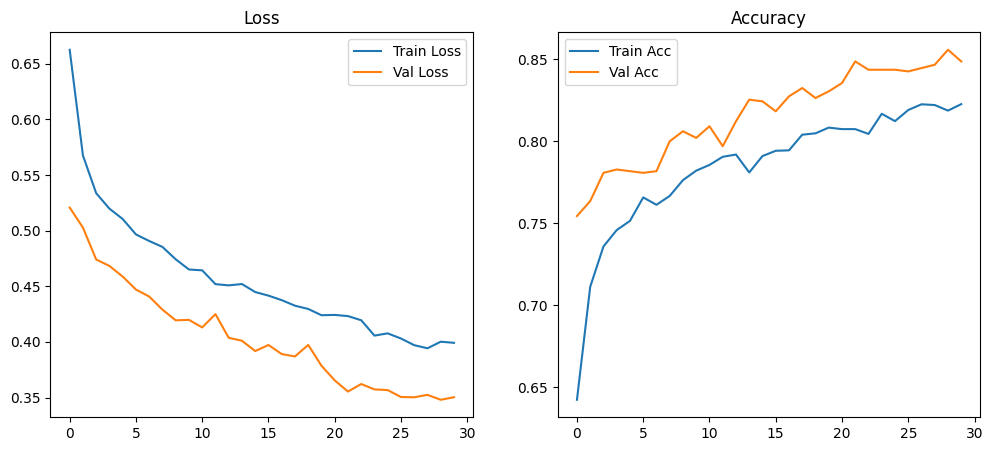

29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 406ms/step
Confusion Matrix:
 [[434  51]
 [ 78 360]]
Classification Report:
                  precision    recall  f1-score   support

bleached_corals       0.85      0.89      0.87       485
 healthy_corals       0.88      0.82      0.85       438

       accuracy                           0.86       923
      macro avg       0.86      0.86      0.86       923
   weighted avg       0.86      0.86      0.86       923



In [9]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%  |  Test Loss: {loss:.4f}")

# 📈 Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()

# 🔍 Confusion Matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n",
      classification_report(y_true, y_pred,
                            target_names=list(test_generator.class_indices.keys())))


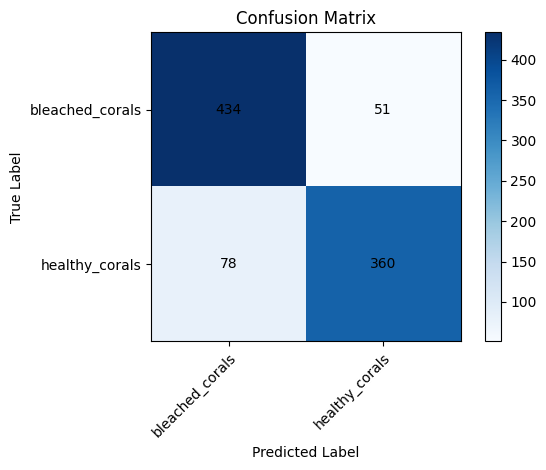

In [10]:
# Plot CM
classes = list(test_generator.class_indices.keys())
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [11]:

# 💾 Save Model
model.save("CNN_model_MobileNet_CoralsClassification.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("CNN_model_MobileNet_CoralsClassification.tflite", "wb").write(tflite_model)
print("Model saved successfully (.h5 + .tflite)")

INFO:tensorflow:Assets written to: /tmp/tmp_fqaetuq/assets


INFO:tensorflow:Assets written to: /tmp/tmp_fqaetuq/assets


Saved artifact at '/tmp/tmp_fqaetuq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  130262784445776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130262784450176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130262784450528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130262784444192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130262784449296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130262784457040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130262784455456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130262784453344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130262784454224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130262784456864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1302627843

W0000 00:00:1762522916.340320  151588 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1762522916.340349  151588 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-11-07 19:11:56.340693: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_fqaetuq
2025-11-07 19:11:56.348885: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-07 19:11:56.348905: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp_fqaetuq
I0000 00:00:1762522916.418298  151588 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-11-07 19:11:56.443097: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-07 19:11:56.997580: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp_fqaetuq
2025-11-07 19:11:57.124825: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 